In [25]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

The *Naive Bayes Classification* algorithm is based on the principle of Bayes' Theorem whihc calculates the probability of data being in a given class based on prior knowledge, i.e. given a set of features, independent variables.


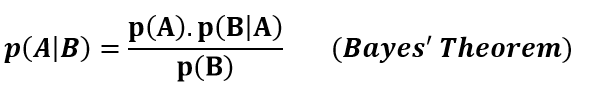

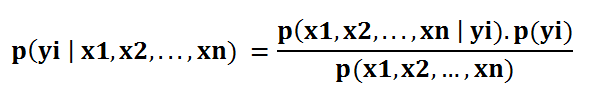

Since the denominator value is a constance, the denominator can be removed from the equation for ease of comparison. And because Naive Bayes assumes that **all features are independent** from each other,  numerator part of the equation can be rewritten as follows:

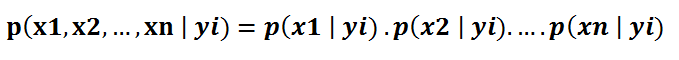

Unlike the above classic Naive Bayes where feature values are **discrete** which allows for easy computation of probability, a variant of Naive Bayes is the **Gaussian Naive Bayes**, which is used when the features are continuous variables. It assumes the values of independent variables are **normally distributed in each class**.

In [26]:
# Dataset
data = load_breast_cancer()
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
df['target'] = data['target']

In [281]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

Calculate **prior probabilities** of each class, i.e. P(Yi)

In [47]:
def get_prior(y_train):
    output = {}
    for label, count in zip(y_train.unique(), y_train.value_counts()):
        output[label] = count/len(y_train)
    return output

get_prior(df.iloc[:,-1])

{0: 0.6274165202108963, 1: 0.37258347978910367}

To estimate the normal distribution of the independent variables, which will then allow us to compute the **gaussian probabilities**, we need the mean and standard deviation of the features under each class.

In [268]:
import scipy
def gaussian_probability(x, mean, std):
    return scipy.stats.norm(loc=mean, scale=std).pdf(x) # probability density
#     return scipy.stats.norm(loc=mean, scale=std).cdf(x)  

# Alternatively, we can compute the gaussian probability with a hand built function
import math
def gaussian_probability_(x, mean, stdev):
    expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2))))
    return (1 / (math.sqrt(2 * math.pi) * stdev)) * expo

In [276]:
# Mean and standard deviation of features under each class
def find_mean_std(X_train, y_train):
    output = {}
    for class_ in set(y_train):
        ix = np.where(y_train==class_)[0]
        x = X_train[ix,:]
        output[class_] = {}
        for col in range(x.shape[1]):
            tmp = {}
            tmp['mean'], tmp['std'] = np.mean(x[:,col]), np.std(x[:,col])
            output[class_][col] = tmp
    return output

# Calculate the probabilities of a given entry belonging to each class
def class_probabilities(class_summaries, test):
    output = {}
    for class_ in class_summaries:
        output[class_] = 1
        for i in range(len(test)):
            value = test[i]
            mean, std = class_summaries[class_][i]['mean'], class_summaries[class_][i]['std']
            output[class_] *= gaussian_probability(value, mean, std)
    return output

# Return the predication with the higher probability
def predict(class_summaries, X_test):
    prediction = []
    for test in X_test:
        prob = class_probabilities(class_summaries, test)
        prediction.append(max(prob, key=prob.get))
    return prediction

# Calculate accuracy of classification
def accuracy(y_pred, y_test):
    n_correct = len(np.where(y_pred==y_test)[0])
    return n_correct / len(y_pred)
    

### Test

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix

# Helper function to plot confusion matrix & show the F1 score
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = [value for value in cm.flatten()]
    labels = [f'{name}\n{count}' for name, count in zip(group_names,group_counts)]
    labels = np.array(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # print F1 Score
    print(f'\nF1 Score: {f1_score(y_test, y_pred):.4f}')

In [333]:
# Test out the algorithm
class_summaries = find_mean_std(X_train.values, y_train.values)
y_pred = predict(class_summaries, X_test.values)
accuracy(y_pred, y_test)

0.9649122807017544

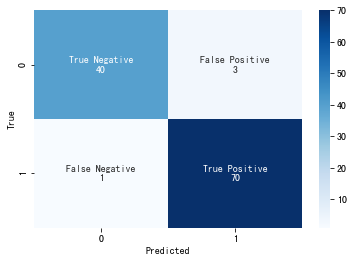


F1 Score: 0.9722


In [334]:
plot_confusion_matrix(y_test, y_pred)

In [335]:
# Compare with sklearn's implementation of Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
accuracy(y_pred, y_test)

0.9736842105263158

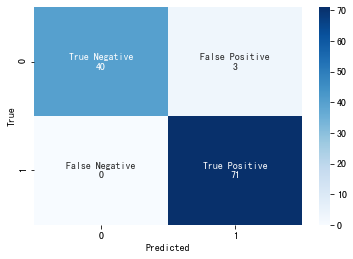


F1 Score: 0.9793


In [336]:
plot_confusion_matrix(y_test, y_pred)